# Performance FastICA on Moebius transformations

## 1. Actual data likelihood
## 2. Amari distance

In [1]:
import ima

In [2]:
import jax
from jax import numpy as jnp
import numpy as np
import distrax
import haiku as hk
from ima.residual import Residual, spectral_norm_init, spectral_normalization, masks_triangular_weights, make_weights_triangular, LipSwish

from jax.experimental.optimizers import adam

In [3]:
key = jax.random.PRNGKey(1)

Introduce a perceptually uniform colormap (more colorblind friendly?).

In [4]:
import cmocean
cmap = cmocean.cm.phase
# Non-perceptually uniform alternative:
# cmap = 'hsv'

# Load data

In [5]:
import os
print(os.path.abspath("."))

/Users/luigigresele/Downloads/independent-mechanism-analysis-fa916ba33b492691a096eb38571d7dc1caf93cbd/examples


In [6]:
data_folder = '/Users/luigigresele/Downloads/data'
S_train = jnp.load(os.path.join(data_folder, 'sources_train.npy'))
S_test = jnp.load(os.path.join(data_folder, 'sources_test.npy'))
X_train = jnp.load(os.path.join(data_folder, 'observation_train.npy'))
X_test = jnp.load(os.path.join(data_folder, 'observation_test.npy'))

In [7]:
# N:=Number of samples
N = S_train.shape[0]
# D:=Number of dimensions
D = S_train.shape[1]

from ima.plotting import cart2pol, pol2cart, scatterplot_variables

_, colors = cart2pol( S_train[:,0], S_train[:,1])

## Plot sources

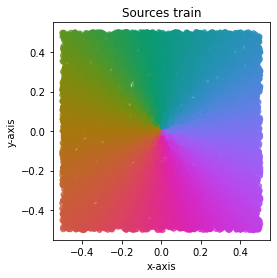

In [8]:
# Plot the sources
scatterplot_variables(S_train[:,:2], 'Sources train', colors=colors, savefig=False, cmap=cmap)

## Plot observations

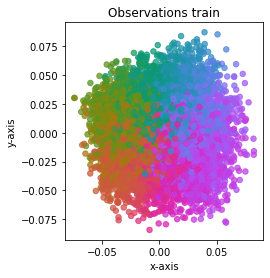

In [9]:
scatterplot_variables(X_train[:,:2], 'Observations train', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

# FastICA: Fit parameters on training data

In [10]:
from sklearn.decomposition import FastICA

In [11]:
ica = FastICA(n_components=D, whiten = True)

In [12]:
S_rec_train = ica.fit_transform(X_train)

In [13]:
A_ = ica.mixing_
#The pseudo-inverse of components_. It is the linear operator that maps independent sources to the data.

In [14]:
B_ = ica.components_ 
#The linear operator to apply to the data to get the independent sources. 
# This is equal to the unmixing matrix when whiten is False, and equal to np.dot(unmixing_matrix, self.whitening_) when whiten is True.

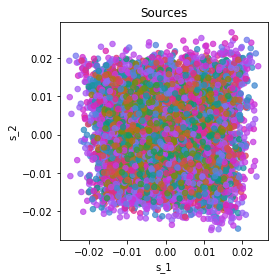

In [15]:
scatterplot_variables(S_rec_train[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [16]:
# scatterplot_variables(np.dot(X-ica.mean_, B_.T)[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [17]:
# scatterplot_variables((np.dot(S_rec, A_.T) + ica.mean_)[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [18]:
# scatterplot_variables(X[:,:2], 'Observations', colors=colors, savefig=False, cmap=cmap)#True, fname="observations_flow")

In [19]:
# We can `prove` that the ICA model applies by reverting the unmixing.

# assert np.allclose(X, np.dot(S_rec, A_.T) + ica.mean_)

print(np.max(np.abs(X_train- (np.dot(S_rec_train, A_.T) + np.mean(X_train, axis=0)))))

2.8036536703357484e-09


In [20]:
# from jax.scipy.stats import logistic

In [21]:
# S_unif = logistic.cdf(S_rec) # use the Logistic cdf here!

In [22]:
#scatterplot_variables(S_rec_train[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

In [23]:
#scatterplot_variables(S_train[:,:2], 'Sources', colors=colors, savefig=False, cmap=cmap)

## Compute CIMA

In [24]:
from ima.metrics import cima_higher_d, cima

In [25]:
# def cima(x):
#     jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
#     J = jac_fn(x)
#     detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
#     out = jnp.sum(jnp.log(jnp.linalg.norm(J, axis=2)), axis=1) - jnp.log(jnp.abs(detJ))
#     return out

In [26]:
jnp.asarray(B_)

DeviceArray([[-0.02549921,  0.22692691,  0.12814619, -0.00743284,
              -0.26091304],
             [-0.117647  , -0.11627899, -0.16501462,  0.22283521,
              -0.1784759 ],
             [-0.33815074, -0.03944701,  0.06910129, -0.12873355,
               0.02884354],
             [ 0.08463384, -0.26452968,  0.16151427, -0.09909454,
              -0.15793517],
             [-0.03617272, -0.01728288,  0.25801793,  0.25571513,
               0.11626974]], dtype=float32)

In [27]:
jac_fn = jax.vmap(jax.jacfwd(lambda y: jnp.dot(y, jnp.asarray(B_).T)))
# c = cima(X, jac_fn)

In [28]:
# jnp.mean(c)

In [29]:
c_hd = cima_higher_d(X_test, jac_fn)
jnp.mean(c_hd)

DeviceArray(0.00033092, dtype=float32)

In [30]:
# loss_final, _ = jax.value_and_grad(loss, 0)(params_final, X)
# likelihood_flow = - (loss_final -lag_mult * jnp.mean(cima_higher_d(X, jac_fn)))
# KL = jnp.mean(obs_likel) - likelihood_flow

In [31]:
# print(KL)

In [32]:
# Check that the Jacobian is **not** triangular
# jac_fn = jax.vmap(jax.jacfwd(lambda y: inv_map.apply(params_final, None, y)))
J = jac_fn(X_test)
# J.shape
mean_J = np.mean(J, axis=0)
# mean_J.shape
print(mean_J)

[[-0.02549921  0.2269268   0.12814619 -0.00743284 -0.2609131 ]
 [-0.11764695 -0.11627897 -0.16501464  0.22283511 -0.17847587]
 [-0.3381508  -0.039447    0.06910127 -0.12873352  0.02884352]
 [ 0.08463383 -0.26452968  0.16151427 -0.09909457 -0.15793516]
 [-0.03617272 -0.01728288  0.258018    0.25571513  0.11626976]]


In [33]:
# for i in range(2):
#     for j in range(2):
#         plt.plot(J[i,j])
#         plt.title(str(i)+","+str(j))
#         plt.show()

In [34]:
# Use the Amari distance for evaluation

## Amari distance evaluation

Rather than the average of the Amari distances between the products of the Jacobians, we should take the Amari distance of the average of the products of the Jacobians.
Otherwise it is hard to account for the fact that the Permutation matrix might be different at different locations

In [35]:
from ima.metrics import jacobian_amari_distance

In [36]:
# Sample P a permutation matrix
Perm = np.array([[0,1],[1,0]])# a permutation matrix

def composed_function(x):
    y = unmixing_moebius(x)
    y = y @ Perm
    z = jnp.tanh(y)
    return z

## MCC based evaluation

In [37]:
S_rec_test = ica.transform(X_test)

In [38]:
import matplotlib.pyplot as plt

In [39]:
from ima.solve_hungarian import SolveHungarian

In [40]:
# import numpy as np
# from scipy.stats import spearmanr
# from scipy.optimize import linear_sum_assignment

# def SolveHungarian( recov, source, correlation='Pearson' ):
#     """
#     compute maximum correlations between true indep components and estimated components 
#     """
#     Ncomp = source.shape[1]
#     if correlation == 'Pearson':
#         CorMat = (np.abs(np.corrcoef( recov.T, source.T ) ) )[:Ncomp, Ncomp:]
#     elif correlation == 'Spearman':
#         rho, _ = np.abs(spearmanr( recov, source ) )
#         CorMat = rho[:Ncomp, Ncomp:]
#     ii = linear_sum_assignment( -1*CorMat )

#     return CorMat[ii].mean(), CorMat, ii

In [41]:
av_corr_spearman, _, indices = SolveHungarian(recov=S_rec_test, source=S_test, correlation = 'Spearman')
print('Spearman correlation true-recovered sources: ', av_corr_spearman)

av_corr_pearson, _, indices = SolveHungarian(recov=S_rec_test, source=S_test, correlation = 'Pearson')
print('Pearson correlation true-recovered sources: ', av_corr_pearson)

Spearman correlation true-recovered sources:  0.9885902894796577
Pearson correlation true-recovered sources:  0.9842216332550375


In [42]:
av_corr_pearson

0.9842216332550375

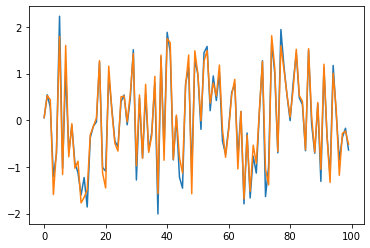

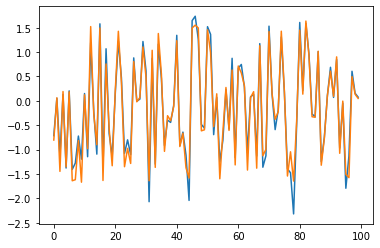

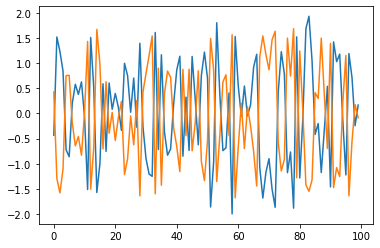

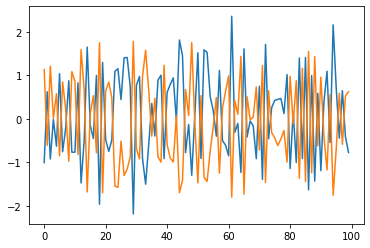

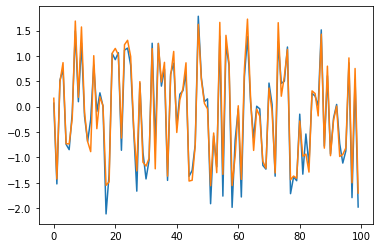

In [43]:
plt.figure()
end = 100
for i in range(S_test.shape[1]):
    plt.plot(S_rec_test[:end,indices[0][i]]/np.std(S_rec_test[:end,indices[0][i]]))
    plt.plot(S_test[:end, indices[1][i]]/np.std(S_test[:end, indices[1][i]]))
    plt.show()

# For this I need to load the transformation parameters

In [117]:
# jac_r_unmix = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_r_unmix = jax.jacfwd(unmixing_moebius)
# jac_r_unmix = jax.jacfwd(composed_function)
# jac_t_mix = jax.jacfwd(mixing_moebius)

In [118]:
jac_r_unmix_vmap = jac_fn #jax.vmap(jac_r_unmix)
jac_t_mix_vmap = jax.vmap(jac_t_mix)

NameError: name 'jac_t_mix' is not defined

In [119]:
jad = jacobian_amari_distance(X_test, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched)

NameError: name 'jac_t_mix_vmap' is not defined

In [120]:
print(jad)

NameError: name 'jad' is not defined

In [121]:
# To do: Visualize the distortion from original sources to reconstructed ones?
# Maybe with a gridplot?

In [122]:
# jac_fn = jax.jacfwd(lambda y: inv_map.apply(params_final, None, y))
# jac_fn = jax.jacfwd(unmixing_moebius)
# jac_fn = jax.jacfwd(composed_function)

In [123]:
# jac_fn_batched = vmap(jac_fn)

In [124]:
c_hd = cima_higher_d(X, jac_fn)
jnp.mean(c_hd)

NameError: name 'X' is not defined

In [125]:
if D==2:
    c = cima(X, jac_fn)
    jnp.mean(c)

In [126]:
jnp.mean(jacobian_amari_distance(X, jac_r_unmix_vmap, jac_t_mix_vmap, unmixing_batched))

NameError: name 'X' is not defined